In [92]:
import os
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

In [93]:
rng = jax.random.PRNGKey(1)

## Part 1: State Space Models

In [94]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C

In [95]:
A, B, C = random_SSM(rng, 3)
print("A shape:", A.shape)
print("B shape:", B.shape)
print("C shape:", C.shape)

A shape: (3, 3)
B shape: (3, 1)
C shape: (1, 3)


### Discrete-time SSM: The Recurrent Representation

In [96]:
def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

In [97]:
Ab, Bb, C = discretize(A, B, C, 0.1)
print("Ab shape:", Ab.shape)
print("Bb shape:", Bb.shape)
print("C shape:",  C.shape)

Ab shape: (3, 3)
Bb shape: (3, 1)
C shape: (1, 3)


In [98]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

In [99]:
u = np.ones((10, 1))
x0 = np.zeros((3,))
x, y = scan_SSM(Ab, Bb, C, u, x0)
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (3,)
y shape: (10, 1)


In [100]:
def run_SSM(A, B, C, u):
    """
    Run a State Space Model (SSM).
    
    Parameters:
        A: Continuous-time state matrix (NxN)
        B: Continuous-time input matrix (Nx1)
        C: Output matrix (1xN)
        u: Input signal (L-dimensional vector)
    
    Returns:
        The output of the state space model after running.
    """
    L = u.shape[0]
    N = A.shape[0]
    
    # Discretize the continuous-time state space model (A, B, C)
    # step is the discretization step size, set to 1.0 / L here
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)
    
    # Run the recursive computation of the state space model
    # Initial state is set to zero vector np.zeros((N,))
    # scan_SSM returns two values, we only take the second one which is the model output
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]

In [101]:
u = np.ones((10,))
y = run_SSM(A, B, C, u)
print("y shape:", y.shape)

y shape: (10, 1)


### Tangent: A Mechanics Example

In [102]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C

In [103]:
@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

In [104]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    os.makedirs('images', exist_ok=True)
    anim.save("images/line.gif", dpi=150, writer="Pillow")

MovieWriter Pillow unavailable; using Pillow instead.


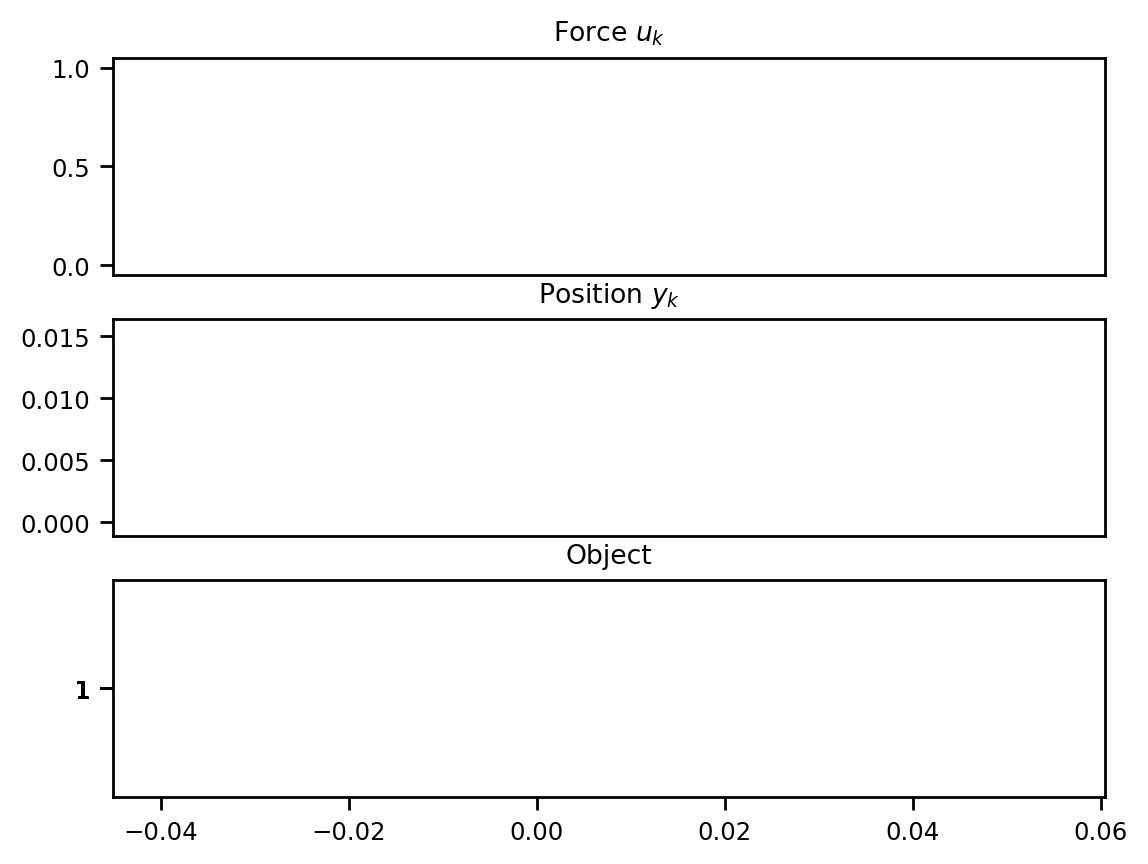

In [105]:
example_ssm()

### Training SSMs: The Convolutional Representation

In [106]:
def K_conv(Ab, Bb, Cb, L):
    return np.array(
        [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
    )

In [107]:
K = K_conv(Ab, Bb, C, L=10)
print("K shape:", K.shape)

K shape: (10,)


In [108]:
def causal_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return np.fft.irfft(out)[: u.shape[0]]

In [109]:
u1 = causal_convolution(u, K, nofft=False)
print("u1 shape:", u1.shape)


u1 shape: (10,)


In [110]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    
    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))

    # Check
    assert np.allclose(rec.ravel(), conv.ravel())

In [111]:
test_cnn_is_rnn(N=4, L=16, step=1.0 / 16)

### An SSM Neural Network

In [112]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)

    return init

In [113]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.N))
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", nn.initializers.ones, (1,))

        # Step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))

        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable("cache", "cache_x_k", np.zeros, (self.N,))

    def __call__(self, u):
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

In [114]:
# Initialize SSM layer
N = 4
L = 10
ssm = SSMLayer(N=N, l_max=L)

# Initialize parameters with a random key
key = jax.random.PRNGKey(0)
params = ssm.init(key, u)

print("\nInitialized parameters:")
for key, value in params.items():
    print(f"{key}:")
    for param_name, param_value in value.items():
        print(f"  {param_name}: shape {param_value.shape}")


Initialized parameters:
params:
  A: shape (4, 4)
  B: shape (4, 1)
  C: shape (1, 4)
  D: shape (1,)
  log_step: shape (1,)
cache:
  cache_x_k: shape (4,)


In [115]:
# Forward pass in CNN mode (decode=False)
output_cnn = ssm.apply(params, u)
print("\nCNN mode output:\n", output_cnn)
print("Output shape:", output_cnn.shape)

# Forward pass in RNN mode (decode=True)
ssm_rnn = SSMLayer(N=N, l_max=L, decode=True)
output_rnn = ssm_rnn.apply(params, u)
print("\nRNN mode output:\n", output_rnn)
print("Output shape:", output_rnn.shape)


CNN mode output:
 [0.991806   0.98362285 0.97545004 0.9672872  0.9591337  0.9509891
 0.9428531  0.93472517 0.92660487 0.9184918 ]
Output shape: (10,)

RNN mode output:
 [0.991806   0.98362285 0.97545004 0.9672872  0.9591337  0.9509891
 0.9428531  0.9347251  0.9266048  0.9184917 ]
Output shape: (10,)


In [116]:
def cloneLayer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )
SSMLayer = cloneLayer(SSMLayer)

In [117]:
class SequenceBlock(nn.Module):
    layer_cls: nn.Module
    layer: dict  # Hyperparameters of inner layer
    dropout: float
    d_model: int
    prenorm: bool = True
    glu: bool = True
    training: bool = True
    decode: bool = False

    def setup(self):
        self.seq = self.layer_cls(**self.layer, decode=self.decode)
        self.norm = nn.LayerNorm()
        self.out = nn.Dense(self.d_model)
        if self.glu:
            self.out2 = nn.Dense(self.d_model)
        self.drop = nn.Dropout(
            self.dropout,
            broadcast_dims=[0],
            deterministic=not self.training,
        )

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)
        x = self.drop(nn.gelu(x))
        if self.glu:
            x = self.out(x) * jax.nn.sigmoid(self.out2(x))
        else:
            x = self.out(x)
        x = skip + self.drop(x)
        if not self.prenorm:
            x = self.norm(x)
        return x

In [118]:
class Embedding(nn.Embed):
    num_embeddings: int     # Vocabulary size
    features: int           # Embedding dimension

    @nn.compact
    def __call__(self, x):
        y = nn.Embed(self.num_embeddings, self.features)(x[..., 0])
        return np.where(x > 0, y, 0.0)

class StackedModel(nn.Module):
    layer_cls: nn.Module    # Layer class to use (e.g., SSMLayer)
    layer: dict             # Layer configuration parameters
    d_output: int           # Output dimension (e.g., vocab size)
    d_model: int            # Model hidden dimension
    n_layers: int           # Number of layers to stack
    prenorm: bool = True    # Whether to apply normalization before layer
    dropout: float = 0.0    # Dropout rate
    embedding: bool = False # Whether to use embedding or dense layer for encoding
    classification: bool = False
    training: bool = True
    decode: bool = False    # Decoding mode flag (for autoregressive generation)

    def setup(self):
        # Input encoder
        if self.embedding:
            # For discrete inputs (e.g., tokens)
            self.encoder = Embedding(self.d_output, self.d_model)
        else:
            # For continuous inputs
            self.encoder = nn.Dense(self.d_model)
        
        # Output decoder
        self.decoder = nn.Dense(self.d_output)
        
        # Stack of sequence processing layers
        self.layers = [
            SequenceBlock(
                layer_cls=self.layer_cls,
                layer=self.layer,
                prenorm=self.prenorm,
                d_model=self.d_model,
                dropout=self.dropout,
                training=self.training,
                decode=self.decode,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        if not self.classification:
            if not self.embedding:
                # Normalize pixel values for image data
                x = x / 255.0
            if not self.decode:
                x = np.pad(x[:-1], [(1, 0), (0, 0)])
        
        # Encode input
        x = self.encoder(x)
        
        # Process through layers
        for layer in self.layers:
            x = layer(x)
        
        if self.classification:
            # Global average pooling for classification
            x = np.mean(x, axis=0)
        
        # Decode to output dimension
        x = self.decoder(x)

        # Apply log softmax for probability distribution
        return nn.log_softmax(x, axis=-1)

In [119]:
BatchStackedModel = nn.vmap(
    StackedModel,
    in_axes=0,
    out_axes=0,
    variable_axes={"params": None, "dropout": None, "cache": 0, "prime": None},
    split_rngs={"params": False, "dropout": True},
)

In [120]:
def test_batch_stacked_model():
    B = 2 # Batch size
    T = 3 # Sequence length
    C = 2 # Input dimension
    O = 3 # Output dimension
    x = np.ones((B, T, C))
    
    print("=== Input Tensor ===")
    print("Shape:", x.shape)

    # Initialize BatchStackedModel
    N = 4                              # State dimension
    
    model = BatchStackedModel(
        layer_cls=SSMLayer,
        layer={"N": N, "l_max": T},    # SSM config
        d_output=O,                    # Output dimension
        d_model=N,                     # Hidden dimension
        n_layers=2,                    # Number of layers
        embedding=False                # Use dense layer
    )
    
    # Initialize parameters
    key = jax.random.PRNGKey(0)
    params = model.init(key, x)
    
    # Forward pass
    output = model.apply(params, x)
    
    print("\n=== Output Tensor ===")
    print("Shape:", output.shape)

# Run test
test_batch_stacked_model()

=== Input Tensor ===
Shape: (2, 3, 2)

=== Output Tensor ===
Shape: (2, 3, 3)


### Part 1b: Addressing Long-Range Dependencies with HiPPO

In [121]:
def make_HiPPO(N):
    P = np.sqrt(1 + 2 * np.arange(N))
    A = P[:, np.newaxis] * P[np.newaxis, :]
    A = np.tril(A) - np.diag(np.arange(N))
    return -A

In [122]:
print(make_HiPPO(4))

[[-1.        -0.        -0.        -0.       ]
 [-1.7320508 -2.        -0.        -0.       ]
 [-2.236068  -3.8729832 -3.        -0.       ]
 [-2.6457512 -4.5825753 -5.9160795 -3.9999995]]


In [123]:
def example_legendre(N=8):
    # Random hidden state as coefficients
    import numpy as np
    import numpy.polynomial.legendre
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # Import this for 3D plotting
    import seaborn

    x = (np.random.rand(N) - 0.5) * 2
    t = np.linspace(-1, 1, 100)
    f = numpy.polynomial.legendre.Legendre(x)(t)

    # Plot
    seaborn.set_context("talk")
    fig = plt.figure(figsize=(15, 10))
    
    # Use add_subplot instead of gca with projection parameter
    ax = fig.add_subplot(111, projection="3d")
    
    ax.plot(
        np.linspace(-25, (N - 1) * 100 + 25, 100),
        [0] * 100,
        zs=-1,
        zdir="x",
        color="black",
    )
    ax.plot(t, f, zs=N * 100, zdir="y", c="r")
    for i in range(N):
        coef = [0] * N
        coef[N - i - 1] = 1
        ax.set_zlim(-4, 4)
        ax.set_yticks([])
        ax.set_zticks([])
        # Plot basis function.
        f = numpy.polynomial.legendre.Legendre(coef)(t)
        ax.bar(
            [100 * i],
            [x[i]],
            zs=-1,
            zdir="x",
            label="x%d" % i,
            color="brown",
            fill=False,
            width=50,
        )
        ax.plot(t, f, zs=100 * i, zdir="y", c="b", alpha=0.5)
    
    ax.view_init(elev=40.0, azim=-45)
    
    # Create directory if it doesn't exist
    import os
    os.makedirs("images", exist_ok=True)
    
    fig.savefig("images/leg.png")
    plt.show()  # Also display the plot

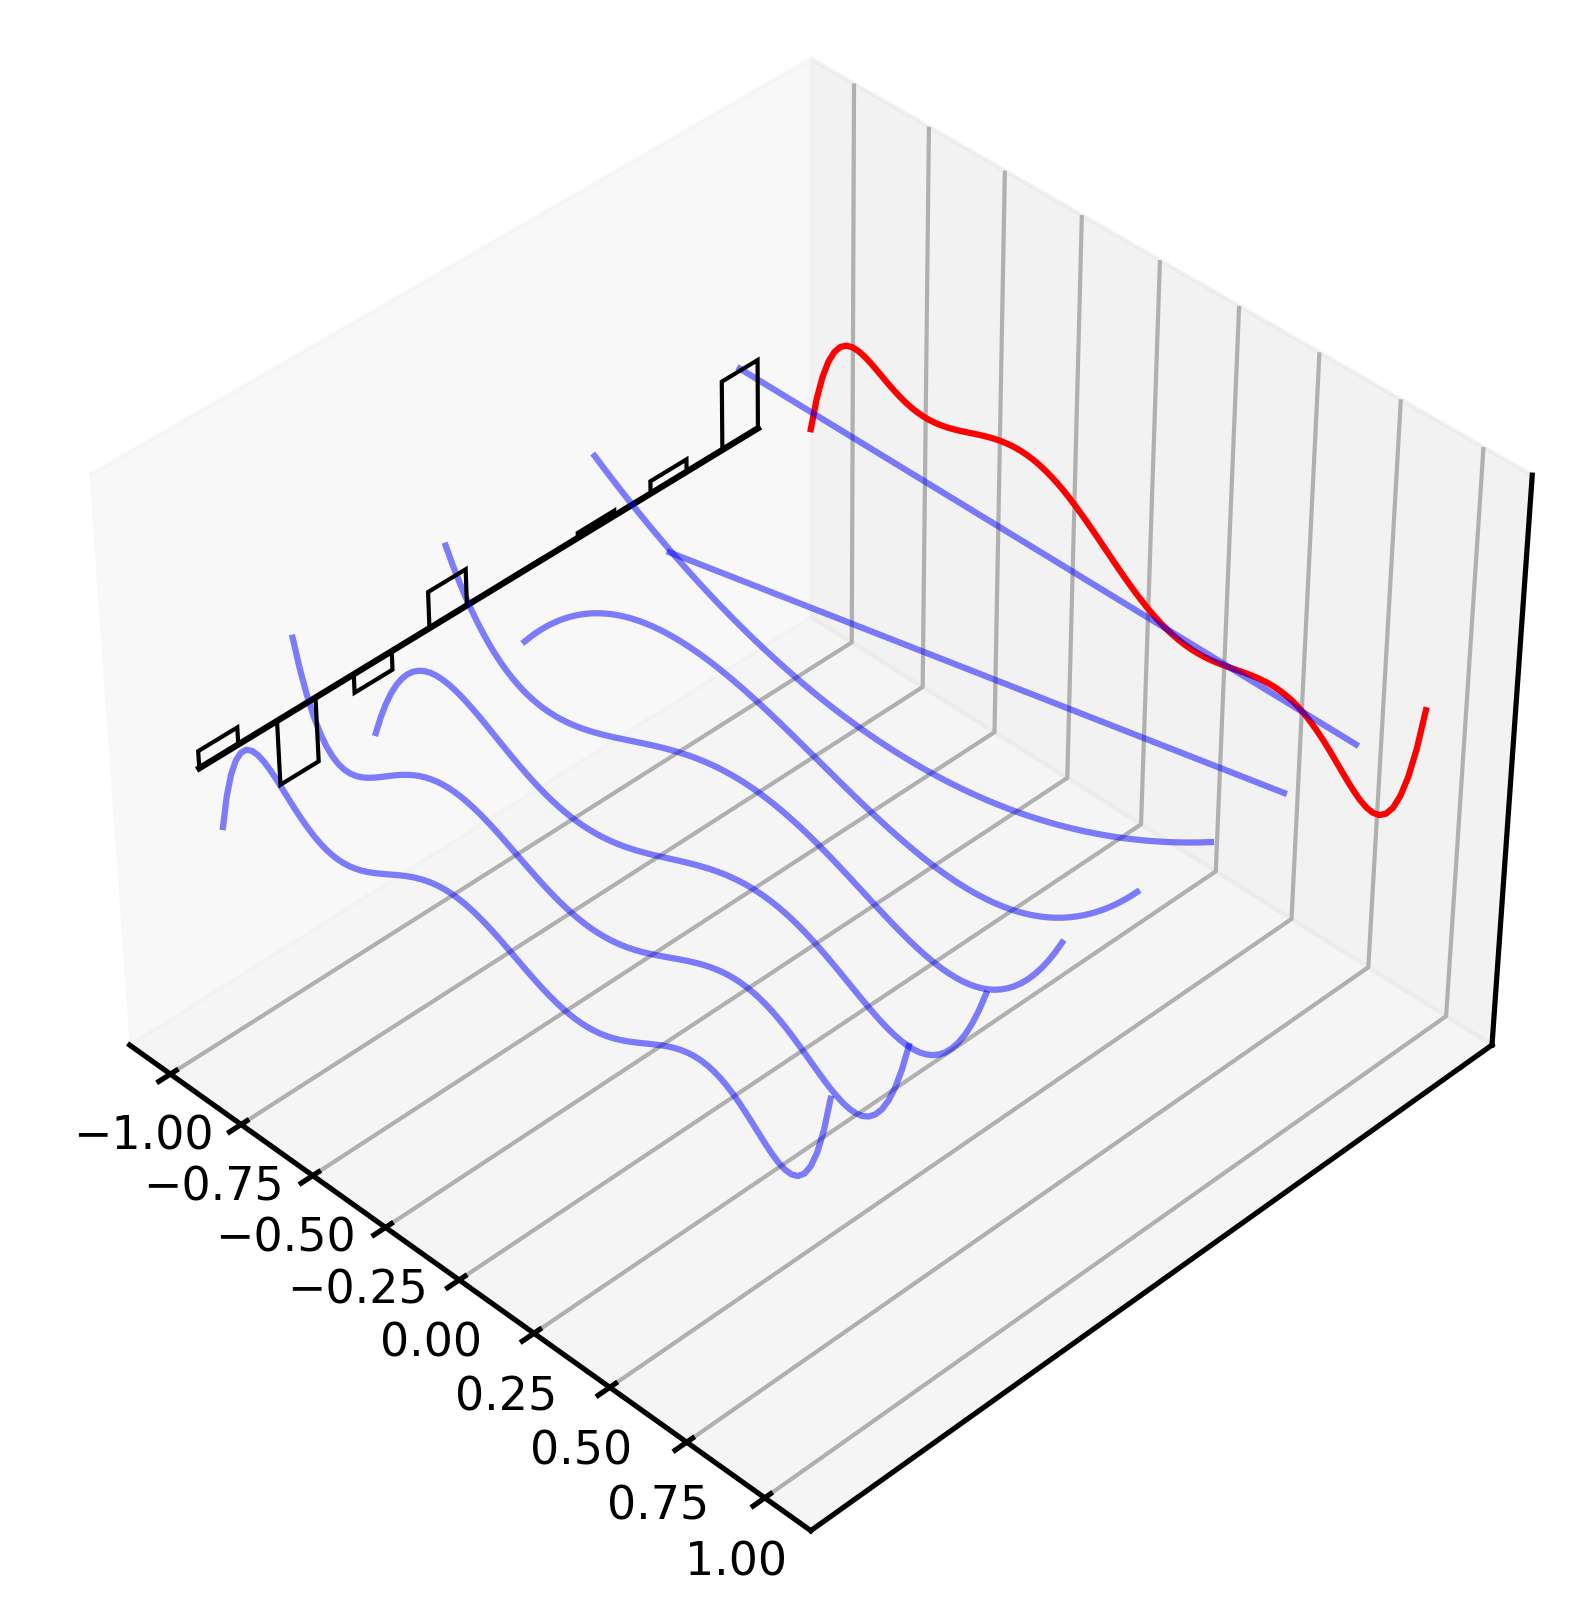

In [124]:
example_legendre(N=8)

## Part 2: Implementing S4

In [125]:
def K_conv(Ab, Bb, Cb, L):
   return np.array(
       [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
   )

### Step 1. SSM Generating Functions

In [126]:
def K_gen_simple(Ab, Bb, Cb, L):
    K = K_conv(Ab, Bb, Cb, L)

    def gen(z):
        return np.sum(K * (z ** np.arange(L)))

    return gen

In [127]:
print("Ab shape:", Ab.shape)
print("Bb shape:", Bb.shape)
print("C shape:", C.shape)
gen_func = K_gen_simple(Ab, Bb, C, L)

# Evaluate at a sample z value
z = 0.5 + 0.5j  # Example complex number
result = gen_func(z)
print(result)

Ab shape: (3, 3)
Bb shape: (3, 1)
C shape: (1, 3)
(0.05515863+0.057052128j)


In [128]:
def conv_from_gen(gen, L):
    # Evaluate at roots of unity
    # Generating function is (-)z-transform, so we evaluate at (-)root
    Omega_L = np.exp((-2j * np.pi) * (np.arange(L) / L))
    atRoots = jax.vmap(gen)(Omega_L)
    # Inverse FFT
    out = np.fft.ifft(atRoots, L).reshape(L)
    return out.real

In [132]:
K_original = K_conv(Ab, Bb, C, L)
K_restore = conv_from_gen(gen_func, L)
print("K_original shape:", K_original)
print("K_restore shape:", K_restore)
assert np.allclose(K_original, K_restore) # Check if they are equal

K_original shape: [0.05626189 0.06676444 0.07916696 0.09381533 0.11111821 0.13155866
 0.15570748 0.18423931 0.21795142 0.25778607]
K_restore shape: [0.05626193 0.06676449 0.07916698 0.09381543 0.11111818 0.13155858
 0.15570748 0.18423925 0.21795137 0.2577861 ]


In [133]:
def K_gen_inverse(Ab, Bb, Cb, L):
    I = np.eye(Ab.shape[0])
    Ab_L = matrix_power(Ab, L)
    Ct = Cb @ (I - Ab_L)
    return lambda z: (Ct.conj() @ inv(I - Ab * z) @ Bb).reshape()

In [135]:
def test_gen_inverse(L=16, N=4):
    ssm = random_SSM(rng, N)
    ssm = discretize(*ssm, 1.0 / L)
    K_original = K_conv(*ssm, L=L)

    K_restore = conv_from_gen(K_gen_inverse(*ssm, L=L), L)
    assert np.allclose(K_restore, K_original)

test_gen_inverse(L=16, N=4)

### Step 2: Diagonal Case

In [136]:
def cauchy_dot(v, omega, lambd):
    return (v / (omega - lambd)).sum()

In [137]:
v = np.array([1.0, 2.0, 3.0])       # tilde{C}_i B_i
omega = 1.5                         # omega = g(z)
lambd = np.array([0.5, 1.0, 1.2])   # Diagonal matrix values

result = cauchy_dot(v, omega, lambd)

print(result)


15.000002


### Step 3: Diagonal Plus Low-Rank

In [138]:
def K_gen_DPLR(Lambda, P, Q, B, C, step, unmat=False):
    aterm = (C.conj(), Q.conj())
    bterm = (B, P)

    def gen(o):
        g = (2.0 / step) * ((1.0 - o) / (1.0 + o))
        c = 2.0 / (1.0 + o)

        def k(a):
            # Checkpoint this calculation for memory efficiency.
            if unmat:
                return jax.remat(cauchy_dot)(a, g, Lambda)
            else:
                return cauchy_dot(a, g, Lambda)

        k00 = k(aterm[0] * bterm[0])
        k01 = k(aterm[0] * bterm[1])
        k10 = k(aterm[1] * bterm[0])
        k11 = k(aterm[1] * bterm[1])
        return c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)

    return gen

In [139]:
@jax.jit
def cauchy(v, omega, lambd):
    """Cauchy matrix multiplication: (n), (l), (n) -> (l)"""
    cauchy_dot = lambda _omega: (v / (_omega - lambd)).sum()
    return jax.vmap(cauchy_dot)(omega)

def kernel_DPLR(Lambda, P, Q, B, C, step, L):
    # Evaluate at roots of unity
    # Generating function is (-)z-transform, so we evaluate at (-)root
    Omega_L = np.exp((-2j * np.pi) * (np.arange(L) / L))

    aterm = (C.conj(), Q.conj())
    bterm = (B, P)

    g = (2.0 / step) * ((1.0 - Omega_L) / (1.0 + Omega_L))
    c = 2.0 / (1.0 + Omega_L)

    # Reduction to core Cauchy kernel
    k00 = cauchy(aterm[0] * bterm[0], g, Lambda)
    k01 = cauchy(aterm[0] * bterm[1], g, Lambda)
    k10 = cauchy(aterm[1] * bterm[0], g, Lambda)
    k11 = cauchy(aterm[1] * bterm[1], g, Lambda)
    
    atRoots = c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)
    out = np.fft.ifft(atRoots, L).reshape(L)
    return out.real

In [143]:
def random_DPLR(rng, N):
    l_r, p_r, q_r, b_r, c_r = jax.random.split(rng, 5)
    Lambda = jax.random.uniform(l_r, (N,))
    P = jax.random.uniform(p_r, (N,))
    Q = jax.random.uniform(q_r, (N,))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return Lambda, P, Q, B, C

### Turning HiPPO to DPLR

In [144]:
def make_NPLR_HiPPO(N):
    # Make -HiPPO
    nhippo = make_HiPPO(N)

    # Add in a rank 1 term. Makes it Normal.
    P = np.sqrt(np.arange(N) + 0.5)

    # HiPPO also specifies the B matrix
    B = np.sqrt(2 * np.arange(N) + 1.0)
    return nhippo, P, B


def make_DPLR_HiPPO(N):
    """Diagonalize NPLR representation"""
    A, P, B = make_NPLR_HiPPO(N)

    S = A + P[:, np.newaxis] * P[np.newaxis, :]

    # Check skew symmetry
    S_diag = np.diagonal(S)
    Lambda_real = np.mean(S_diag) * np.ones_like(S_diag)
    # assert np.allclose(Lambda_real, S_diag, atol=1e-3)

    # Diagonalize S to V \Lambda V^*
    Lambda_imag, V = eigh(S * -1j)

    P = V.conj().T @ P
    B = V.conj().T @ B
    return Lambda_real + 1j * Lambda_imag, P, B, V

In [150]:
def test_gen_dplr(L=16, N=4):
    I = np.eye(4)

    # Create a DPLR A matrix and discretize
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    print(f"Lambda Shape: {Lambda.shape}")
    print(f"P Shape: {P.shape}")
    print(f"Q Shape: {P.shape}")
    print(f"B Shape: {B.shape}")

    A = np.diag(Lambda) - P[:, np.newaxis] @ P[:, np.newaxis].conj().T
    _, _, C = random_SSM(rng, N)
    print(f"A shape: {A.shape}")
    print('====')

    Ab, Bb, Cb = discretize(A, B, C, 1.0 / L)
    print(f"Ab shape: {Ab.shape}")
    print(f"Bb shape: {Bb.shape}")
    print(f"Cb shape: {Cb.shape}")
    print('====')

    K_original = K_conv(Ab, Bb, Cb.conj(), L=L)

    # Compare to the DPLR generating function approach.
    C = (I - matrix_power(Ab, L)).conj().T @ Cb.ravel()
    print(f"Tile C shape: {C.shape}")
    print('====')

    K_dplr = kernel_DPLR(Lambda, P, P, B, C, step=1.0 / L, L=L)
    print(f"K_original shape: {K_original.shape}")
    print(f"K_dplr shape: {K_dplr.shape}")
    print('====')

    assert np.allclose(K_original.real, K_dplr.real)

test_gen_dplr(L=10, N=4)

Lambda Shape: (4,)
P Shape: (4,)
Q Shape: (4,)
B Shape: (4,)
A shape: (4, 4)
====
Ab shape: (4, 4)
Bb shape: (4,)
Cb shape: (1, 4)
====
Tile C shape: (4,)
====
K_original shape: (10,)
K_dplr shape: (10,)
====


### Diagonal Plus Low-Rank RNN

In [151]:
def discrete_DPLR(Lambda, P, Q, B, C, step, L):
    # Convert parameters to matrices
    B = B[:, np.newaxis]
    Ct = C[np.newaxis, :]

    N = Lambda.shape[0]
    A = np.diag(Lambda) - P[:, np.newaxis] @ Q[:, np.newaxis].conj().T
    I = np.eye(N)

    # Forward Euler
    A0 = (2.0 / step) * I + A

    # Backward Euler
    D = np.diag(1.0 / ((2.0 / step) - Lambda))
    Qc = Q.conj().T.reshape(1, -1)
    P2 = P.reshape(-1, 1)
    A1 = D - (D @ P2 * (1.0 / (1 + (Qc @ D @ P2))) * Qc @ D)

    # A bar and B bar
    Ab = A1 @ A0
    Bb = 2 * A1 @ B

    # Recover Cbar from Ct
    Cb = Ct @ inv(I - matrix_power(Ab, L)).conj()
    return Ab, Bb, Cb.conj()

In [152]:
def test_nplr(N=8):
    A2, P, B = make_NPLR_HiPPO(N)
    Lambda, Pc, Bc, V = make_DPLR_HiPPO(N)
    Vc = V.conj().T
    P = P[:, np.newaxis]
    Pc = Pc[:, np.newaxis]
    Lambda = np.diag(Lambda)

    A3 = V @ Lambda @ Vc - (P @ P.T)  # Test NPLR
    A4 = V @ (Lambda - Pc @ Pc.conj().T) @ Vc  # Test DPLR
    assert np.allclose(A2, A3, atol=1e-4, rtol=1e-4)
    assert np.allclose(A2, A4, atol=1e-4, rtol=1e-4)

test_nplr(N=8)

### Final Check

In [154]:
def test_conversion(N=8, L=16):
    step = 1.0 / L
    # Compute a HiPPO NPLR matrix.
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    # Random complex Ct
    C = normal(dtype=np.complex64)(rng, (N,))

    # CNN form.
    K = kernel_DPLR(Lambda, P, P, B, C, step, L)

    # RNN form.
    Ab, Bb, Cb = discrete_DPLR(Lambda, P, P, B, C, step, L)
    K2 = K_conv(Ab, Bb, Cb, L=L)
    assert np.allclose(K.real, K2.real, atol=1e-5, rtol=1e-5)

    # Apply CNN
    u = np.arange(L) * 1.0
    y1 = causal_convolution(u, K.real)

    # Apply RNN
    _, y2 = scan_SSM(
        Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)).astype(np.complex64)
    )
    assert np.allclose(y1, y2.reshape(-1).real, atol=1e-4, rtol=1e-4)

test_conversion(N=4, L=10)

## Part 3: S4 in Practice

### S4 CNN / RNN Layer

In [155]:
# Factory for constant initializer in Flax
def init(x):
    def _init(key, shape):
        assert shape == x.shape
        return x

    return _init
def hippo_initializer(N):
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    return init(Lambda.real), init(Lambda.imag), init(P), init(B)

In [156]:
class S4Layer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    # Special parameters with multiplicative factor on lr and no weight decay (handled by main train script)
    lr = {
        "Lambda_re": 0.1,
        "Lambda_im": 0.1,
        "P": 0.1,
        "B": 0.1,
        "log_step": 0.1,
    }

    def setup(self):
        # Learned Parameters (C is complex!)
        init_A_re, init_A_im, init_P, init_B = hippo_initializer(self.N)
        self.Lambda_re = self.param("Lambda_re", init_A_re, (self.N,))
        self.Lambda_im = self.param("Lambda_im", init_A_im, (self.N,))
        # Ensure the real part of Lambda is negative
        # (described in the SaShiMi follow-up to S4)
        self.Lambda = np.clip(self.Lambda_re, None, -1e-4) + 1j * self.Lambda_im
        self.P = self.param("P", init_P, (self.N,))
        self.B = self.param("B", init_B, (self.N,))
        # C should be init as standard normal
        # This doesn't work due to how JAX handles complex optimizers https://github.com/deepmind/optax/issues/196
        # self.C = self.param("C", normal(stddev=1.0, dtype=np.complex64), (self.N,))
        self.C = self.param("C", normal(stddev=0.5**0.5), (self.N, 2))
        self.C = self.C[..., 0] + 1j * self.C[..., 1]
        self.D = self.param("D", nn.initializers.ones, (1,))
        self.step = np.exp(self.param("log_step", log_step_initializer(), (1,)))

        if not self.decode:
            # CNN mode, compute kernel.
            self.K = kernel_DPLR(
                self.Lambda,
                self.P,
                self.P,
                self.B,
                self.C,
                self.step,
                self.l_max,
            )

        else:
            # RNN mode, discretize
            # Flax trick to cache discrete form during decoding.
            def init_discrete():
                return discrete_DPLR(
                    self.Lambda,
                    self.P,
                    self.P,
                    self.B,
                    self.C,
                    self.step,
                    self.l_max,
                )

            ssm_var = self.variable("prime", "ssm", init_discrete)
            if self.is_mutable_collection("prime"):
                ssm_var.value = init_discrete()
            self.ssm = ssm_var.value

            # RNN Cache
            self.x_k_1 = self.variable(
                "cache", "cache_x_k", np.zeros, (self.N,), np.complex64
            )

    def __call__(self, u):
        # This is identical to SSM Layer
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

S4Layer = cloneLayer(S4Layer)

In [157]:
def sample(model, params, prime, cache, x, start, end, rng):
    def loop(i, cur):
        x, rng, cache = cur
        r, rng = jax.random.split(rng)
        out, vars = model.apply(
            {"params": params, "prime": prime, "cache": cache},
            x[:, np.arange(1, 2) * i],
            mutable=["cache"],
        )

        def update(x, out):
            p = jax.random.categorical(r, out[0])
            x = x.at[i + 1, 0].set(p)
            return x

        x = jax.vmap(update)(x, out)
        return x, rng, vars["cache"].unfreeze()

    return jax.lax.fori_loop(start, end, jax.jit(loop), (x, rng, cache))[0]

In [158]:
def init_recurrence(model, params, init_x, rng):
    variables = model.init(rng, init_x)
    vars = {
        "params": params,
        "cache": variables["cache"].unfreeze(),
        "prime": variables["prime"].unfreeze(),
    }
    print("[*] Priming")
    _, prime_vars = model.apply(vars, init_x, mutable=["prime"])
    return vars["params"], prime_vars["prime"], vars["cache"]

In [159]:
def sample_checkpoint(path, model, length, rng):
    from flax.training import checkpoints

    start = np.zeros((1, length, 1), dtype=int)

    print("[*] Initializing from checkpoint %s" % path)
    state = checkpoints.restore_checkpoint(path, None)
    assert "params" in state
    params, prime, cache = init_recurrence(model, state["params"], start, rng)
    print("[*] Sampling output")
    return sample(model, params, prime, cache, start, 0, length - 1, rng)

### Experiments: MNIST

In [160]:
def sample_image_prefix(
    params,
    model,
    # length,
    rng,
    dataloader,
    prefix=300,
    # bsz=32,
    imshape=(28, 28),
    n_batches=None,
    save=True,
):
    """Sample a grayscale image represented as intensities in [0, 255]"""
    import matplotlib.pyplot as plt
    import numpy as onp

    # from .data import Datasets
    # BATCH = bsz
    # start = np.zeros((BATCH, length), dtype=int)
    # start = np.zeros((BATCH, length, 1), dtype=int)
    start = np.array(next(iter(dataloader))[0].numpy())
    start = np.zeros_like(start)
    # params, prime, cache = init_recurrence(model, params, start[:, :-1], rng)
    params, prime, cache = init_recurrence(model, params, start, rng)

    BATCH = start.shape[0]
    START = prefix
    LENGTH = start.shape[1]
    assert LENGTH == onp.prod(imshape)

    # _, dataloader, _, _, _ = Datasets["mnist"](bsz=BATCH)
    it = iter(dataloader)
    for j, im in enumerate(it):
        if n_batches is not None and j >= n_batches:
            break

        image = im[0].numpy()
        image = np.pad(
            image[:, :-1, :], [(0, 0), (1, 0), (0, 0)], constant_values=0
        )
        cur = onp.array(image)
        # cur[:, START + 1 :, 0] = 0
        # cur = np.pad(cur[:, :-1, 0], [(0, 0), (1, 0)], constant_values=256)
        cur = np.array(cur[:, :])

        # Cache the first `start` inputs.
        out, vars = model.apply(
            {"params": params, "prime": prime, "cache": cache},
            cur[:, np.arange(0, START)],
            mutable=["cache"],
        )
        cache = vars["cache"].unfreeze()
        out = sample(model, params, prime, cache, cur, START, LENGTH - 1, rng)

        # Visualization
        out = out.reshape(BATCH, *imshape)
        final = onp.zeros((BATCH, *imshape, 3))
        final2 = onp.zeros((BATCH, *imshape, 3))
        final[:, :, :, 0] = out
        f = final.reshape(BATCH, LENGTH, 3)
        i = image.reshape(BATCH, LENGTH)
        f[:, :START, 1] = i[:, :START]
        f[:, :START, 2] = i[:, :START]
        f = final2.reshape(BATCH, LENGTH, 3)
        f[:, :, 1] = i
        f[:, :START, 0] = i[:, :START]
        f[:, :START, 2] = i[:, :START]
        if save:
            for k in range(BATCH):
                fig, (ax1, ax2) = plt.subplots(ncols=2)
                ax1.set_title("Sampled")
                ax1.imshow(final[k] / 256.0)
                ax2.set_title("True")
                ax1.axis("off")
                ax2.axis("off")
                ax2.imshow(final2[k] / 256.0)
                fig.savefig("im%d.%d.png" % (j, k))
                plt.close()
                print(f"Sampled batch {j} image {k}")
    return final, final2